# Lesson 38: Introduction to image processing with scikit-image

(c) 2017 Justin Bois and Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l38_intro_to_image_processing.ipynb).*

In [1]:
import numpy as np

# Our image processing tools
import skimage.filters
import skimage.io
import skimage.morphology
import skimage.exposure

# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In this tutorial, we will learn some basic techniques for image processing using [`scikit-image`](http://scikit-image.org) with Python.

## Image processing tools for Python

There are many image processing tools available for Python. Some of them, such as ITK and OpenCV are mature image processing packages that have bindings for Python, allowing easy use of their functionality. Others were developed specifically for Python. Some of the many packages are

* [`scikit-image`](http://scikit-image.org)
* [`scipy.ndimage`](http://docs.scipy.org/doc/scipy/reference/ndimage.html)
* [Open CV](http://opencv.org) (extensive computer vision package)
* [Cell Profiler](http://www.cellprofiler.org) (Broad Institute at MIT)
* [Insight Segmentation and Registration Toolkit](http://www.itk.org) (ITK, used in medical imaging, supported by the NIH)
* [Fiji](http://fiji.sc) and [ImageJ](http://developer.imagej.net) support [Jython](http://www.jython.org) scripting

The first two packages are standard with Anaconda. They provide a set of basic image processing tools, with more sophisticated packages such as ITK and Fiji supplying many more bells and whistles. If in the future you have more demanding image processing requirements, the other packages can prove very useful. 

These days, there are lots of machine learning based packages for image segmentation, but few of these are mature packages at the moment. In future editions of the bootcamp, as these techniques and packages mature, we may use them.

We will almost exclusively use `scikit-image` along with the standard tools from NumPy.  The package `scipy.ndimage` is quite useful, but we will use `scikit-image`, since it has expanded functionality. A potential annoyance with `skimage` is that the main package has minimal functionality, and you must import subpackages as needed. For example, to load and view images, you will need to import `skimage.io`. Importantly, `skimage` is well-documented, and you can access the documentation at [http://scikit-image.org/](http://scikit-image.org/).

We will explore `skimage`’s capabilities and some basic image processing techniques through example.  In this lesson, we will take a brightfield and a fluorescent image of bacteria and perform **segmentation**, that is the identification of each pixel in the image as being bacterial or background.

## Loading and viewing 12-bit images

We will now load and view the test images we will use for segmentation.  We load the image using the `skimage.io.imread()`.  The image is stored as a NumPy array.  Each entry in the array is a pixel value.  This is an important point: **a digital image is data**!  It is a set of numbers with spatial positions.

Today, we'll be looking at some images of  *Bacillus subtilis*, a gram-positive bacterium famous for its ability to enter [a form of 'suspended animation' known as sporulation](https://en.wikipedia.org/wiki/Sporulation_in_Bacillus_subtilis) when environmental conditions get rough. In these images, all cells have been engineered to express Cyan Fluorescent Protein (CFP) once they enter a particular genetic state known as [competence](https://en.wikipedia.org/wiki/Natural_competence). These cells have been imaged under phase contrast (`bsub_100x_phase.tif`) and epifluorescence (`bsub_100x_cfp.tif`) microscopy. These images were acquired by Caltech graduate student (and 2016 bootcamp TA) Griffin Chure.

To display the images, we do not want Seaborn's default white gridlines, so we can use context management with Seaborn by setting the axes style to `'dark'`.

In [2]:
# Load the phase contrast image.
im_phase = skimage.io.imread('data/bsub_100x_phase.tif')

# Display the image, set Seaborn style 'dark' to avoid grid lines
with sns.axes_style('dark'):
    skimage.io.imshow(im_phase)

/Users/Justin/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


We get a warning and then a strange looking picture!  The warning is that we have a low dynamic range.  We get this warning because `skimage` assumes that images with integer pixel values are either 8-bit, 16-bit, or 32-bit.  This image, as is often the case with images acquired with scientific cameras, were acquired with a 12-bit camera.  This means that the pixel values range from 0 to $2^{12}-1=4095$.  This is much less than what we would expect for a maximal pixel value for a 16-bit image, $2^{16}-1 = 65535$. Opening these images using the standard photo viewing tools on your computer (such as Preview on macOS or Windows Photo Viewer on Windows) will show a black image.

So, to view the images in their full range, we should divide by the maximal pixel value.

In [3]:
# Display the image
with sns.axes_style('dark'):
    skimage.io.imshow(im_phase / im_phase.max())

## Lookup tables

As an alternative to stretching the image and using `skimage.io.imshow` to view the image, we can use `matploblib`'s image viewing function, which automatically adjusts the image.  We will need to specify a `gray` colormap to look at it.  In fact, while we're at it, we can specify whatever colormap we want.

In [4]:
with sns.axes_style('dark'):
    # Get subplots
    fig, ax = plt.subplots(2, 2, figsize=(8,6))

    # Display various LUTs
    ax[0,0].imshow(im_phase, cmap=plt.cm.gray)
    ax[0,1].imshow(im_phase, cmap=plt.cm.RdBu_r)
    ax[1,0].imshow(im_phase, cmap=plt.cm.viridis)
    ax[1,1].imshow(im_phase, cmap=plt.cm.copper)

We did a few new things here.  First, we use the `plt.subplots()` function to generate subplots.  Second, we used the `imshow()` method of the `axes` object to display the images.   Lastly, we specified the **colormap** to be used for showing the image. This specifies how the pixel values are interpreted as they are displayed.  For a grayscale colormap, high pixel values are more white, and low pixel values are more black.

In image processing, a colormap is called a **lookup table** (LUT).  A LUT is a mapping of pixel values to a color. This sometimes helps visualize images, especially when we use false coloring.  Remember, a digital image is data, and false coloring an image is **not** manipulation of data.  It is simply a different way of plotting it.

As we just saw, we specify a lookup table with a **colormap**.  There are plenty available in `matplotlib`.  There is lots of debate about that the best colormaps (LUTs) are. The data visualization community seems to universally reject using rainbow colormaps. See, e.g., [D. Borland and R. M. Taylor, Rainbow Color Map (Still) Considered Harmful, IEEE Computer Graphics and Applications, 27,14-17, 2007](https://www.computer.org/csdl/mags/cg/2007/02/mcg2007020014-abs.html). In the upper right example, I use a hue-diverging colorscale, which goes from blue to red, as people accustomed to rainbow colormaps expect, but in a perceptually ordered fashion.  Matplotlib's default colormap, [`viridis`](http://matplotlib.org/style_changes.html) is my favorite. This colormap [has been designed](http://bids.github.io/colormap/) to be perceptually flat across a large range of values.

Importantly, the false coloring helps use see that the intensity of the pixel values in the middle of cell clusters are similar to those of the background which will become an issue, as we will see, as we begin our segmentation.

## Introductory segmentation

As mentioned before, **segmentation** is the process by which we separate regions of an image according to their identity for easier analysis. E.g., if we have an image of bacteria and we want to determine what is "bacteria" and what is "not bacteria," we would do some segmentation. We will use bacterial test images for this purpose.

### Histograms

As we begin segmentation, remember that viewing an image is just a way of plotting the digital image data.  We can also plot a **histogram**.  This helps us see some patterns in the pixel values and is often an important first step toward segmentation.

The histogram of an image is simply a list of counts of pixel values. When we plot the histogram, we can often readily see breaks in which pixel values are most frequently encountered. There are many ways of looking at histograms. I’ll show you my preferred way.

In [8]:
# Get the histogram data
hist_phase, bins_phase = skimage.exposure.histogram(im_phase)

# Use matplotlib to make a pretty plot of histogram data
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('pixel value')
ax.set_ylabel('count')
_ = ax.fill_between(bins_phase, hist_phase, alpha=0.75)

We see that there are is some structure in the histogram of the phase image. While our eyes are drawn to the large peak around 380, we should keep in mind that our bacteria are black on a bright background and occupy only a small area of the image. We can see a smaller peak in the vicinity of 200 which likely represent our bugs of interest. The peak to the right is brighter, so likely represents the background.  Therefore, if we can find where the valley between the two peaks is, we may take pixels with intensity below that value to be bacteria and those above to be background.  Eyeballing it, I think this critical pixel value is about 300.

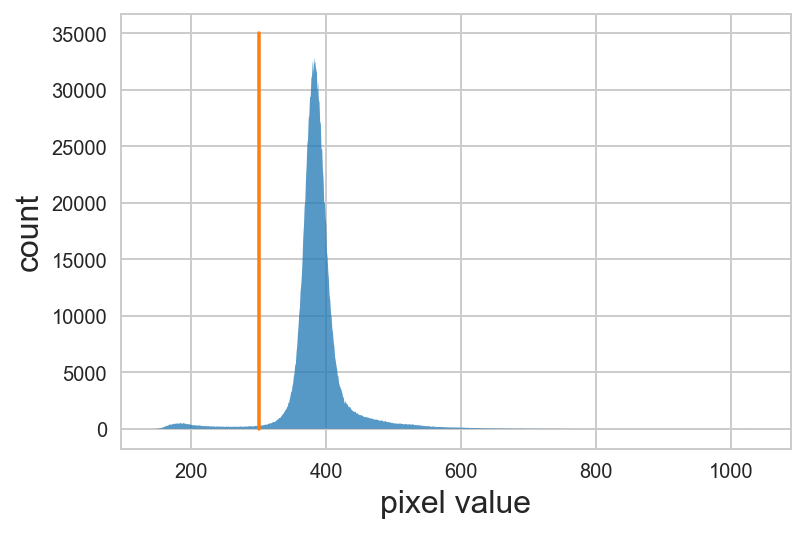

In [11]:
# Use matplotlib to make a pretty plot of histogram data
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('pixel value')
ax.set_ylabel('count')
_ = ax.fill_between(bins_phase, hist_phase, alpha=0.75)
_ = ax.plot([300, 300], [0, 35000], linestyle='-', marker='None', color=colors[1])

### Thresholding

The process of taking pixels above or below a certain value is called **thresholding**.  It is one of the simplest ways to segment an image.  We call every pixel with a value below 300 part of a bacterium and everything above *not* part of a bacterium.

In [16]:
# Threshold value, as obtained by eye
thresh_phase = 300

# Generate thresholded image
im_phase_bw = im_phase < thresh_phase

We can overlay these images to get a good view.  To do this, we will make an RGB image, and saturate the green channel where the thresholded image is white.

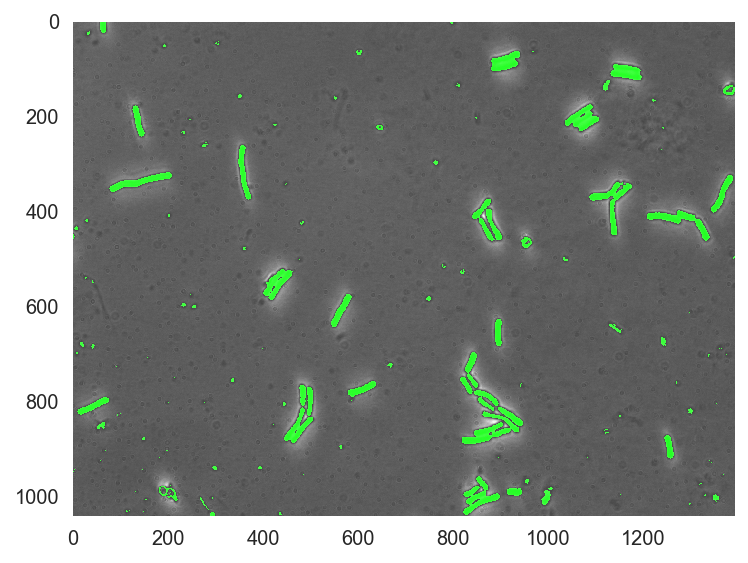

In [20]:
# Build RGB image by stacking grayscale images
im_phase_rgb = np.dstack(3 * [im_phase / np.max(im_phase)])

# Saturate green channel wherever there are white pixels in thresh image
im_phase_rgb[im_phase_bw, 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    skimage.io.imshow(im_phase_rgb)

We see that we did a decent job finding bacteria, but we also pick up quite a bit of garbage sitting around the cells. We can also see that in some of the bigger clusters, we do not effectively label the bacteria in the middle of colonies.  This is because of the "halo" of high intensity signal near boundaries of the bacteria that we get from using phase contrast microscopy.

### Using the CFP channel

One way around these issues is to use bacteria that constitutively express a fluorescent protein and to segment in using the fluorescent channel.  Let's try the same procedure with the CFP channel.  First, let's look at the image.

/Users/Justin/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


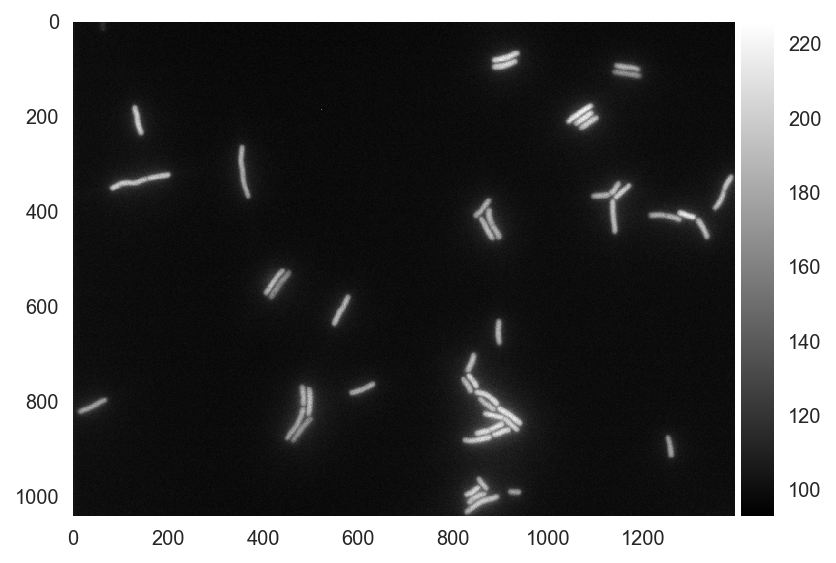

In [22]:
# Load image
im_cfp = skimage.io.imread('data/bsub_100x_CFP.tif')

# Display the image
with sns.axes_style('dark'):
    skimage.io.imshow(im_cfp, cmap=plt.cm.gray)

We can also look with a different LUT.

/Users/Justin/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


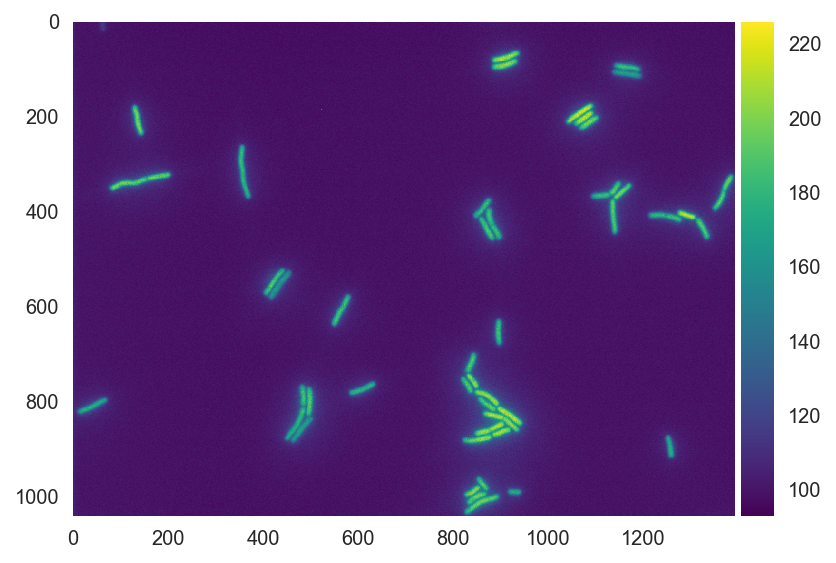

In [23]:
# Display the image with the viridis color map
with sns.axes_style('dark'):
    skimage.io.imshow(im_cfp, cmap=plt.cm.viridis)

We see that the bacteria are typically brighter than the background (which is impressively uniform), so this might help us in segmentation.

### Filtering noise: the median filter

While it may not be obvious from this image, the non-bacterial pixels are not completely dark due to autofluorescence of the immobilization substrate as well as some issues in our camera. In fact, the camera on which these images were acquired has a handful of "bad" pixels which are always much higher than the "real" value. This could cause issues in situations where we would want to make quantitative measurements of intensity. We can zoom in on one of these "bad" pixels below. 

In [25]:
with sns.axes_style('dark'):
    skimage.io.imshow(im_cfp[150:250,450:550] / im_cfp.max(), cmap=plt.cm.viridis)

/Users/Justin/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


We see a single bright pixel. In addition to throwing off our colormap a bit, this could alter the measured intensity of a cell if there happen to be any other bad pixels hiding within the bacteria. We can remove this noise by using a **median filter**.  The concept is simple. We take a shape of pixels, called a **structuring element**, and pass it over the image. The value of the center pixel in the max is replaced by the median value of all pixels in the mask. To do this, we first need to construct a mask. This is done using the `skimage.morphology` module. The filtering is then done using `skimage.filters.rank.median()`. Let’s try it with a 3$\times$3 square mask.

In [26]:
# Make the structuring element
selem = skimage.morphology.square(3)

# Perform the median filter
im_cfp_filt = skimage.filters.median(im_cfp, selem)

# Show filtered image with the viridis LUT. 
with sns.axes_style('dark'):
    skimage.io.imshow(im_cfp_filt, cmap=plt.cm.viridis)

/Users/Justin/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


Now that we have dealt with the noisy pixels, we can now see more clearly that some cells are very bright compared with others and we can see that the scale on our colorbar has changed a bit as well.   We also have an image that makes more sense; we have eliminated the noise.

### Thresholding in the CFP channel

We'll proceed by plotting the histogram and finding the threshold value.

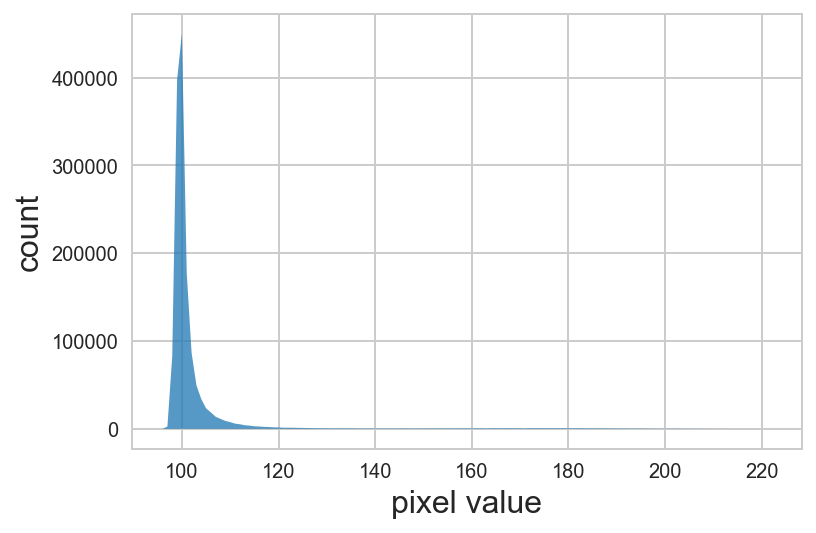

In [30]:
# Get the histogram data
hist_cfp, bins_cfp = skimage.exposure.histogram(im_cfp_filt)

# Use matplotlib to make a pretty plot of histogram data
fig, ax = plt.subplots(1, 1)
_ = ax.set_xlabel('pixel value')
_ = ax.set_ylabel('count')
_ = ax.fill_between(bins_cfp, hist_cfp, alpha=0.75)

Yeesh. There are lots of bright pixels, but it is kind of hard to see where (or even if) there is valley in the histogram. It sometimes helps to plot the histogram with the y-axis on a log scale. When we do this, we can eyeball the threshold value to be about 140.

In [32]:
# Set y to be on a log scale
ax.set_yscale('log')

# Plot eye-balled threshold
_ = ax.plot([140, 140], [0, 500000], color=colors[1])

fig

Now let's try thresholding the image.

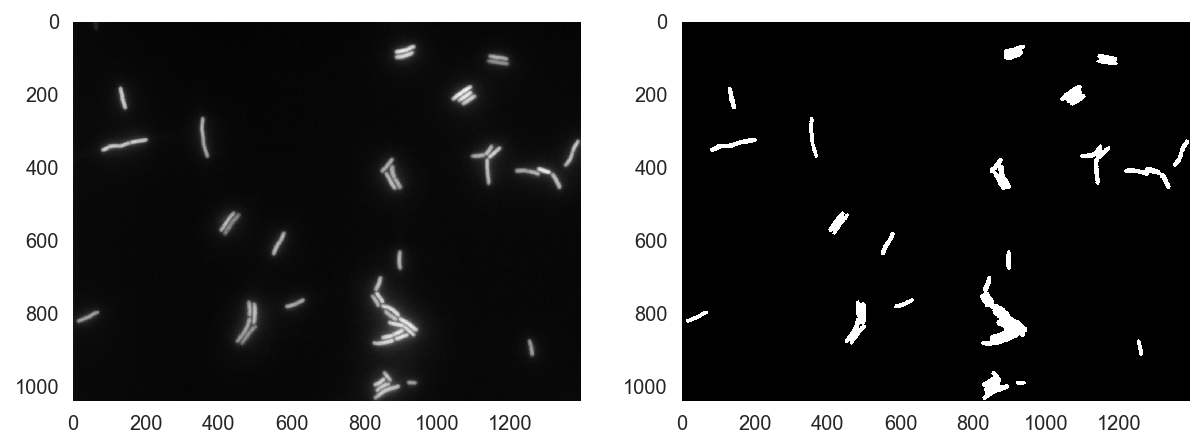

In [33]:
# Threshold value, as obtained by eye
thresh_cfp = 140

# Generate thresholded image
im_cfp_bw = im_cfp_filt > thresh_cfp

# Display phase and thresholded image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(im_cfp_filt, cmap=plt.cm.gray)
    ax[1].imshow(im_cfp_bw, cmap=plt.cm.gray)

Looks like we're doing much better!  Let's try overlapping the images now.

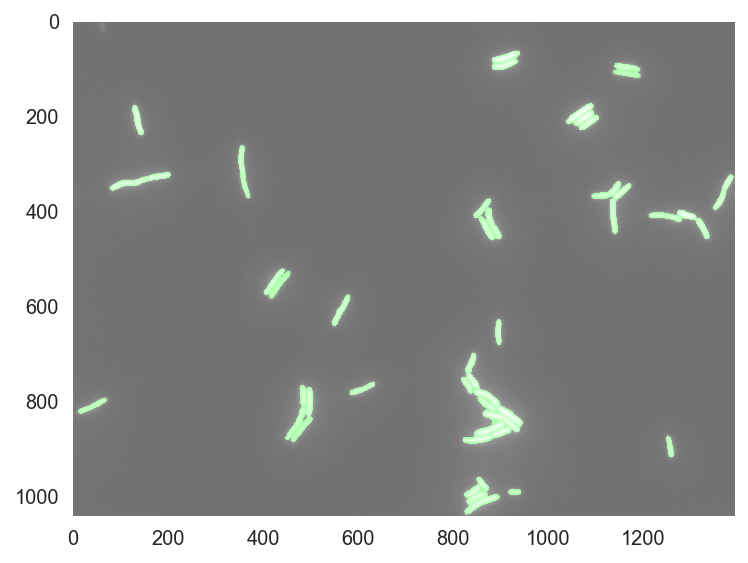

In [34]:
# Build RGB image by stacking grayscale images
im_cfp_rgb = np.dstack(3 * [im_cfp_filt / im_cfp_filt.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_cfp_rgb[im_cfp_bw, 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    skimage.io.imshow(im_cfp_rgb)

Very nice! In general, it is often much easier to segment bacteria with fluorescence.

### Otsu's method for thresholding

It turns out that there is an automated way to find the threshold value, as opposed to eyeballing it like we have been doing.  Otsu's method provides this functionality.

In [35]:
# Compute Otsu thresholds for phase and cfp
thresh_phase_otsu = skimage.filters.threshold_otsu(im_phase)
thresh_cfp_otsu = skimage.filters.threshold_otsu(im_cfp_filt)

# Compare results to eyeballing it
print('Phase by eye: ', thresh_phase, '   CFP by eye: ', thresh_cfp)
print('Phase by Otsu:', thresh_phase_otsu,   
      '   CFP by Otsu:', thresh_cfp_otsu)

Phase by eye:  300    CFP by eye:  140
Phase by Otsu: 437    CFP by Otsu: 135


We see that for the CFP channel, the Otsu method did very well.  However, for phase, we see a big difference.  This is because the Otsu method assumes a bimodal distribution of pixels.  If we look at the histograms on a log scale, we see more clearly that the phase image has a long tail, which will trip up the Otsu algorithm.  The moral of the story is that you can use automated thresholding, but you should always do sanity checks to make sure it is working as expected.

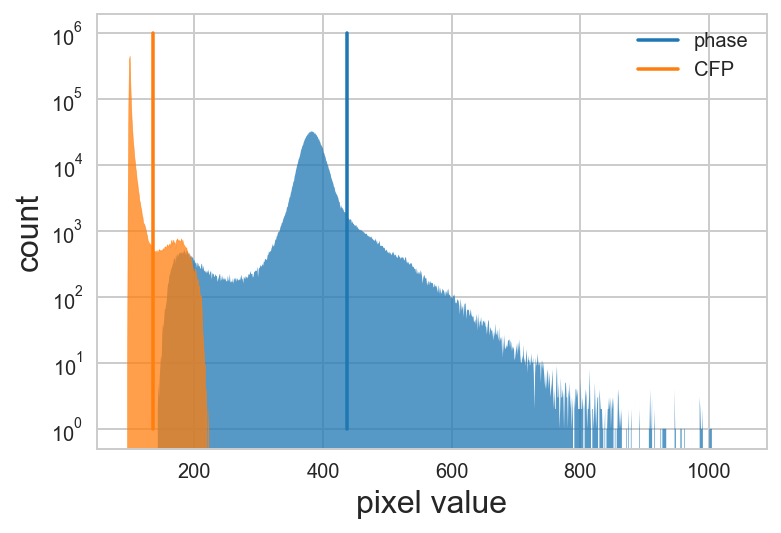

In [38]:
# Set up figure
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('pixel value')
ax.set_ylabel('count')
ax.set_yscale('log')

# Histograms with thresholds
_ = ax.fill_between(bins_phase, hist_phase, alpha=0.75)
_ = ax.fill_between(bins_cfp, hist_cfp, alpha=0.75, color=colors[1])
_ = ax.plot([thresh_phase_otsu, thresh_phase_otsu], [1, 1e6], color=colors[0])
_ = ax.plot([thresh_cfp_otsu, thresh_cfp_otsu], [1, 1e6], color=colors[1])
ax.legend(('phase', 'CFP'), loc='upper right');

## Determining the bacterial area

Now that we have a thresholded image, we can determine the total area taken up by bacteria.  It's as simple as summing up the pixel values of the thresholded image!

In [40]:
# Compute bacterial area
bacterial_area_pix = (im_cfp_filt > thresh_cfp_otsu).sum()

# Print out the result
print('bacterial area =', bacterial_area_pix, 'pixels')

bacterial area = 37945 pixels


If we want to get the total area that is bacterial in units of µm, we could use the interpixel distances to get the area represented by each pixel.  For this setup, the interpixel distance is 0.0636 µm.  We can then compute the bacterial area as follows.

In [41]:
# Define interpixel distance
interpix_dist = 0.063 # microns

# Compute bacterial area
bacterial_area_micron = bacterial_area_pix * interpix_dist**2

# Print total area
print('bacterial area =', bacterial_area_micron, 'square microns')

bacterial area = 150.603705 square microns
